# Inflow Domain Example Schematic

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 2

In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.patheffects as pe

import centered_response as cr
from wofunits import wofunits

import warnings
warnings.filterwarnings("ignore")

## Manually set case, time, inflow domain specs, etc. for the desired plotting

In [2]:
################################ Set case/plotting specs  #######################################

    # save scatter plots?
save = False

    # select case
#case = '201905172100'
#case = '201905172200'
#case = '201905202030'
#case = '201905262000'
case = '201905282230'

    # select time and variables
lead_time = 30 # lead time in minutes
statevar, respvar = 'T2','UH25-30MIN'

    # domain thresholding specs
inflow_region = 'if'
pthres = 0.05
pstat_sign = 'all'
ang_thres = 360
nf_dist = 40 # distance bound of near-inflow domain
ff_dist = 120 # distance bound of far-inflow domain
ang_bound1, ang_bound2 = 40, 230 # angular domain bounds relative to the storm motion
domain_lag = 0 # distance lag of domain origin to storm center in km

    # define file paths
sensdir = wofunits.paths['sens_path'] # sensitivity data path
wofsdir = wofunits.paths['wofs_path'] # WoFS data path
sm_path = wofunits.paths['sm_path'] # storm motion data path
outplot_path = wofunits.paths['outplot_path'] # plot output path

#cmap = colors.ListedColormap(['silver', 'yellow', 'orange'])
cmap = colors.ListedColormap(['gainsboro', 'gold', 'darkorange'])

## Process data

In [3]:
################################ Process chosen spec selections  #######################################
    
    # pull case specs
wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

respvar_filestr = respvar.replace('-','_')

    # define state and response time as datetime objects
resp_time = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')
state_time = resp_time - datetime.timedelta(minutes=lead_time)

    # define file strings for given variables and time
file_sens = f'{sensdir}/sens_center_{case}/stats_{respvar}_max_{str(resp_time.hour).zfill(2)}_{str(resp_time.minute).zfill(2)}_00_{statevar}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
file_ref = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_center_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'

    # open netCDF files
ds_sens = xr.open_dataset(file_sens)
ds_ref = xr.open_dataset(file_ref)

    # define variables for overview plots
sens = ds_sens.stdsens
cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))[0]
pstat = ds_sens.pstat.values

################################ Define storm-relative aspects  #######################################

    # define observed MRMS storm centers to center storm on plot
df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)

    # string to 
pdstr = f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'

    # open storm motion csv files
sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')

    # average storm motion components at chosen time
sm_mean_x = np.nanmean(sm_x[:-1][pdstr].values)
sm_mean_y = np.nanmean(sm_y[:-1][pdstr].values)

    # calculate angle of storm motion relative to positive x-axis
storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)

    # create 2D x and y storm-relative grids
xmesh,ymesh = cr.xy_mesh(case, state_time)
dist = (xmesh**2 + ymesh**2)**0.5 # convert to 2D meshgrid

    # calculate storm-relative angle of each gridpoint 
ang_tot = cr.calc_ang_tot(xmesh,ymesh,storm_ang=storm_ang)

    # calculate angle difference between SR gridpoint position and SR 
ang_diff = cr.srw_ang_diff(case, state_time)

vals = np.full(shape=dist.shape, fill_value=2)

vals = np.where(  (dist > nf_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres), 1, vals)
vals = np.where( (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2)  | (ang_diff > ang_thres), 0, vals)


## Plot Fig. 2: Inflow Domain Schematic

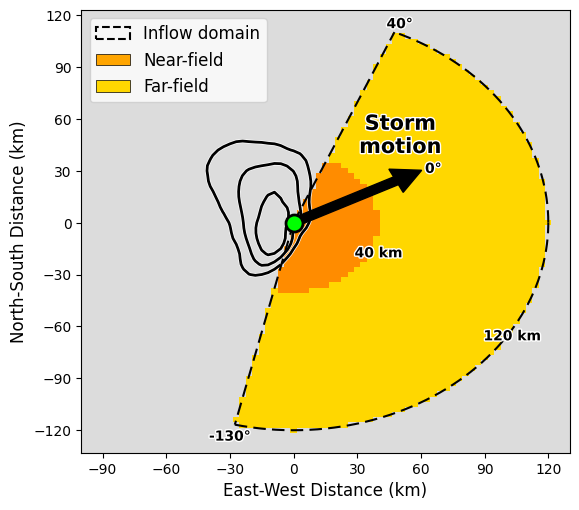

In [4]:
################# Plot sensitivity ######################

arrow = mpatches.Arrow(x=0, y=0, dx=sm_mean_x*4, dy=sm_mean_y*4, width=25, color='k', zorder=998)

fig, ax = plt.subplots(1,1,figsize=(6.3,5.75))

#cb = plt.contourf(xmesh, ymesh, sens, cmap='RdBu_r', levels=np.arange(-60,61,5), extend='both')

plt.contour(xmesh, ymesh, cref, levels=[20,35,50], colors='w', linewidths=3)
plt.contour(xmesh, ymesh, cref, levels=[20,35,50], colors='k', linewidths=2)

#plt.contourf(xmesh, ymesh, abs(pstat), [0, 0.1], colors='none', hatches=['////'], extend='lower')

plt.pcolormesh(xmesh, ymesh, vals, cmap=cmap, vmin=0, vmax=2)

cr.plot_domain(storm_ang = storm_ang, 
            ang_bounds = (ang_bound1, ang_bound2), dashes=(6,3), lw=1.5)

plt.scatter(0,0, marker='o', s=150, lw=2, edgecolor='k', facecolor='lime', zorder=999)

ax.add_patch(arrow)

### Annotating text
plt.text(x=sm_mean_x*4-10, y=sm_mean_y*4 + 10, s='Storm\nmotion', 
        horizontalalignment='center', weight='bold', size=15, c='k', path_effects=[pe.withStroke(linewidth=2, foreground='w')])
plt.text(x=sm_mean_x*4+5.5, y=sm_mean_y*4 - 1.5, s='0°', 
        horizontalalignment='center', weight='bold', size=10, c='k', path_effects=[pe.withStroke(linewidth=2, foreground='w')])
plt.text(x=50, y=112.5, s='40°', 
        horizontalalignment='center', weight='bold', size=10, c='k', path_effects=[pe.withStroke(linewidth=2, foreground='w')])
plt.text(x=-30, y=-126, s='-130°', 
        horizontalalignment='center', weight='bold', size=10, c='k', path_effects=[pe.withStroke(linewidth=2, foreground='w')])
plt.text(x=40, y=-20, s='40 km', 
        horizontalalignment='center', weight='bold', size=10, c='k', path_effects=[pe.withStroke(linewidth=2, foreground='w')])
plt.text(x=103, y=-68, s='120 km', 
        horizontalalignment='center', weight='bold', size=10, c='k', path_effects=[pe.withStroke(linewidth=2, foreground='w')])



plt.xticks(np.arange(-120,121,30))
plt.yticks(np.arange(-120,121,30))

#cbar = plt.colorbar(cb, label=wofunits.labels['UH-30SWT25'])
#cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=8)

plt.xlim(-100,130)
plt.ylim(-133,123)

plt.xlabel('East-West Distance (km)', size=12)
plt.ylabel('North-South Distance (km)', size=12)

#plt.title('Inflow Domain', weight='bold', size=16)

rect_nf = mpatches.Rectangle((0,0), 0, height=0.9, lw=0.5, edgecolor='k', facecolor='orange')
rect_ff = mpatches.Rectangle((0,0), 0, height=0.9, lw=0.5, edgecolor='k', facecolor='gold')
rect_if = mpatches.Rectangle((0,0), 0, height=0.9, lw=1.5, edgecolor='k', ls='--', facecolor='None')

ax.legend(handles=[rect_if, rect_nf, rect_ff], 
          labels=['Inflow domain', 'Near-field', 'Far-field'],
          loc='upper left',fancybox=True, fontsize=12)


if save == True:
    plt.savefig(fname=f'{outplot_path}/inflow_domain.png', dpi=300, bbox_inches='tight', facecolor='w')